# VGG

**AlexNet的问题是不规则，需要规则的框架**

**网络：更大，更深**

- 更多的全连接层（很贵）
- 更多的卷积层
- **将卷积层组合层块**

### VGG块

> 更大更深的`AlexNet`

- 3x3比5x5窄，但是深，效果更好
- VGG块
    - 使用n层m通道的3x3（padding=1）
    - 2x2 stride=2 的最大池化
- 多个VGG块之后添加全连接层

### 思想

- 使用可重复的块构建深度神经网络
- 不同卷积块的个数可以得到不同复杂度的变种

In [1]:
import torch
from torch import nn
import torchvision
import os
import time
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

In [2]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        ))
        layers.append(
            nn.ReLU()
        )
        in_channels = out_channels
    layers.append(nn.MaxPool2d(
        kernel_size=2,
        stride=2
    ))
    return nn.Sequential(*layers) # 解包

In [3]:
conv_arch = ( # 由于最大池化，相当于每层宽高除 2
    (1, 64),
    (1, 128),
    (2, 256),
    (2, 512),
    (2, 1024)
)

# 5块 224/2^5 = 7

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append((vgg_block(
            num_convs, in_channels, out_channels
        )))
        in_channels = out_channels
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )

net = vgg(conv_arch)

In [4]:
"""为了能跑,使用一个小的网络"""
ratio=4
small_conv_arch=[(pair[0], pair[1]//ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

X = torch.rand(size=(1, 1, 224, 224), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(f"{layer.__class__.__name__} :\t {X.shape}")

Sequential :	 torch.Size([1, 16, 112, 112])
Sequential :	 torch.Size([1, 32, 56, 56])
Sequential :	 torch.Size([1, 64, 28, 28])
Sequential :	 torch.Size([1, 128, 14, 14])
Sequential :	 torch.Size([1, 256, 7, 7])
Flatten :	 torch.Size([1, 12544])
Linear :	 torch.Size([1, 4096])
ReLU :	 torch.Size([1, 4096])
Dropout :	 torch.Size([1, 4096])
Linear :	 torch.Size([1, 4096])
ReLU :	 torch.Size([1, 4096])
Dropout :	 torch.Size([1, 4096])
Linear :	 torch.Size([1, 10])


/usr/local/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
resize = 224
batch_size=256
num_cpu_cores = os.cpu_count()
trans = [torchvision.transforms.ToTensor()]
if resize is not None:
    trans.insert(0, torchvision.transforms.Resize(resize))
trans = torchvision.transforms.Compose(trans)
train_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)


/usr/local/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y   # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter):
    """使用GPU计算模型在数据集上的精度"""
    device = try_gpu() 
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def try_gpu(i = 0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    else:
        return torch.device('cpu')
    

def train_gpu(net, train_iter, test_iter, num_epochs, lr):
    device = try_gpu()
    print(f'training on {device}')

    def init_weight(m):
        if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)

    net.to(device)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    
    train_l, train_acc, test_acc, time_l = [], [], [], []

    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        start = time.perf_counter()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat=y_hat, y=y), X.shape[0])
        end = time.perf_counter()
        train_l.append(metric[0] / metric[2])
        train_acc.append(metric[1] / metric[2])
        test_acc.append(evaluate_accuracy_gpu(net, test_iter))
        time_l.append(end-start)
        print(f"Epoch {epoch+1}, Using Time : {time_l[-1]:.3f}, train_acc : {train_acc[-1]:.4f} test_acc : {test_acc[-1]:.4f}")
    """绘图"""
    backend_inline.set_matplotlib_formats("svg")
    plt.rcParams['figure.figsize']=(7, 5)
    plt.plot(list(range(num_epochs)), train_l, 'm--')
    plt.plot(list(range(num_epochs)), train_acc, 'r:')
    plt.plot(list(range(num_epochs)), test_acc, 'g-')

    plt.legend(["train_loss", "train_accuracy", "test_accuracy"])
    plt.xlabel('epochs')
    plt.ylabel('percent')
    plt.title(f'{num_epochs} epochs')
    plt.grid(True)

    print(f"Test accuracy : {test_acc[-1]:.3f}")
    print(f'{metric[2] * num_epochs / sum(time_l):.1f} examples/sec on {str(torch.cuda.get_device_name())}')

training on cuda:0
Epoch 1, Using Time : 73.569, train_acc : 0.4702 test_acc : 0.7081
Epoch 2, Using Time : 74.684, train_acc : 0.8077 test_acc : 0.8419
Epoch 3, Using Time : 75.281, train_acc : 0.8510 test_acc : 0.8589
Epoch 4, Using Time : 75.539, train_acc : 0.8716 test_acc : 0.8641
Epoch 5, Using Time : 75.635, train_acc : 0.8837 test_acc : 0.8856
Epoch 6, Using Time : 75.737, train_acc : 0.8930 test_acc : 0.8888
Epoch 7, Using Time : 75.702, train_acc : 0.9015 test_acc : 0.8562
Epoch 8, Using Time : 75.845, train_acc : 0.9076 test_acc : 0.8959
Epoch 9, Using Time : 75.726, train_acc : 0.9117 test_acc : 0.8975
Epoch 10, Using Time : 75.739, train_acc : 0.9167 test_acc : 0.8859
Test accuracy : 0.886
796.3 examples/sec on Tesla T4
Total Time : 803.464958


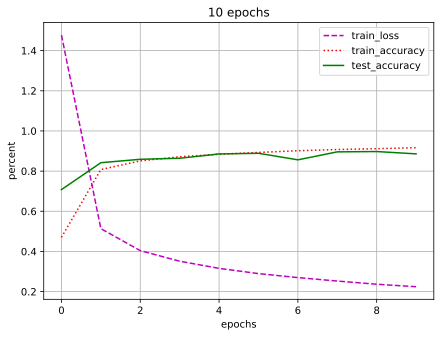

In [7]:
lr, num_epochs = 0.05, 10
start = time.perf_counter()
train_gpu(net, train_iter, test_iter, num_epochs, lr)
end = time.perf_counter()
print(f"Total Time : {end-start:3f}")

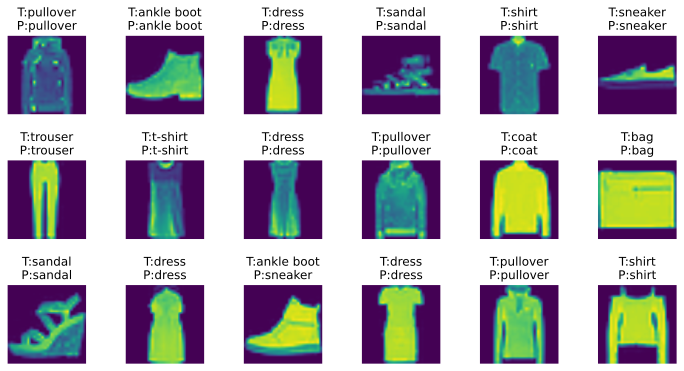

In [8]:
""" 获得标签索引对应文本"""
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', \
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

""" 打印图片 """
def show_img(imgs, num_rows, num_cols, title=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    plt.rcParams["figure.figsize"] = figsize
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(title[i])
        plt.axis('off')
        if torch.is_tensor(imgs[i].numpy()):
            plt.imshow(imgs[i].numpy())
        else:
            plt.imshow(imgs[i])

def predtic_ch3(net, test_iter, rows, cols):
    n = rows * cols
    for X, y in test_iter:
        break
    X = X.to(try_gpu())
    trues = get_fashion_mnist_labels(y)
    predicts = get_fashion_mnist_labels(net(X).argmax(axis=1))
    title = [f"T:{true}\nP:{predict}" for true, predict in zip(trues, predicts)]
    X = X.to(torch.device('cpu'))
    show_img(X[0:n].reshape([n, 224, 224]), rows, cols, title=title[0:n], scale=2)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
predtic_ch3(net, test_iter, 3, 6)

In [9]:
torch.cuda.empty_cache()